GT4Py - GridTools Framework

Copyright (c) 2014-2024, ETH Zurich
All rights reserved.

Please, refer to the LICENSE file in the root directory.
SPDX-License-Identifier: BSD-3-Clause

# The diagnostic step of the isentropic dynamical core

The isentropic model is a hydrostatic fully-compressible atmospheric model which uses the potential temperature $\theta$ as vertical terrain-following coordinate. The potential temperature of an air parcel is defined as the temperature the parcel would have if brought adiabatically to the reference pressure $p_{\text{ref}} = 1000$ hPa. Thermodynamical calculations yield

\begin{equation*}
    \theta := T \left( \dfrac{p_{\text{ref}}}{p} \right)^{R / c_p} \, ,
\end{equation*}

where $T$ is the air temperature, $p$ is the air pressure, $R$ is the gas constant for dry air and $c_p$ is the specific heat of dry air at constant pressure. In the isentropic reference frame the continuity equation can be conveniently formulated in terms of the so-called *isentropic density* $\sigma$, defined by

\begin{equation*}
    \sigma := - \dfrac{1}{g} \dfrac{\partial p}{\partial z} \, .
\end{equation*}

Here, $g$ is the gravitational acceleration and $z$ is the height above the surface. Whereas, the pressure gradient term occurring in the momentum equations involves the Montgomery potential $M$,

\begin{equation*}
    M := \pi \theta + g z \, ,
\end{equation*}

where $\pi$ denotes the Exner function,

\begin{equation*}
    \pi := c_p \left( \dfrac{p}{p_{\text{ref}}} \right)^{R / c_p} \, .
\end{equation*}

The air pressure, the Exner function, the Montgomery potential and the height of the isentropic surfaces can be retrieved with the help of $\sigma$. This forms the *diagnostic step* of the isentropic dynamical core.



Imports and customizable settings
--

In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np

import gt4py.storage
import gt4py.cartesian.gtscript as gtscript

# grid size
nx = 32
ny = 32
nz = 64

# brunt-vaisala frequency
bv = 0.01

# physical constants
rd = 287.05
g = 9.81
p_ref = 1.0e5
cp = 1004.0

Stencil definition and compilation
--

In [2]:
# gridtools4py settings
backend = (
    "numpy"  # options: "numpy", "gt:cpu_ifirst", "gt:cpu_kfirst", "gt:gpu", "dace:cpu", "dace:gpu"
)
backend_opts = {"verbose": True} if backend.startswith("gt") else {}
dtype = np.float64
origin = (3, 3, 0)
rebuild = True

externals = {"rd": rd, "g": g, "p_ref": p_ref, "cp": cp}

start_time = time.time()


@gtscript.stencil(backend=backend, externals=externals, **backend_opts)
def diagnostic_step(
    in_theta: gtscript.Field[dtype],
    in_hs: gtscript.Field[dtype],
    in_s: gtscript.Field[dtype],
    inout_p: gtscript.Field[dtype],
    out_exn: gtscript.Field[dtype],
    inout_mtg: gtscript.Field[dtype],
    inout_h: gtscript.Field[dtype],
    *,
    dtheta: float,
    pt: float,
):
    # retrieve the pressure
    with computation(FORWARD), interval(0, 1):
        inout_p = pt
    with computation(FORWARD), interval(1, None):
        inout_p = inout_p[0, 0, -1] + g * dtheta * in_s[0, 0, -1]

    # compute the Exner function
    with computation(PARALLEL), interval(0, None):
        out_exn = cp * (inout_p[0, 0, 0] / p_ref) ** (rd / cp)

    # compute the Montgomery potential
    with computation(BACKWARD), interval(-2, -1):
        mtg_s = in_theta[0, 0, 1] * out_exn[0, 0, 1] + g * in_hs[0, 0, 1]
        inout_mtg = mtg_s + 0.5 * dtheta * out_exn[0, 0, 1]
    with computation(BACKWARD), interval(0, -2):
        inout_mtg = inout_mtg[0, 0, 1] + dtheta * out_exn[0, 0, 1]

    # compute the geometric height of the isentropes
    with computation(BACKWARD), interval(-1, None):
        inout_h = in_hs[0, 0, 0]
    with computation(BACKWARD), interval(0, -1):
        inout_h = inout_h[0, 0, 1] - rd * (
            in_theta[0, 0, 0] * out_exn[0, 0, 0] + in_theta[0, 0, 1] * out_exn[0, 0, 1]
        ) * (inout_p[0, 0, 0] - inout_p[0, 0, 1]) / (cp * g * (inout_p[0, 0, 0] + inout_p[0, 0, 1]))


print("\n- Compilation time: ", time.time() - start_time)


- Compilation time:  0.045667171478271484


Computations
--

In [3]:
# define the vertical grid
theta1d = np.linspace(340.0, 280.0, nz + 1)
theta = gt4py.storage.zeros((nx, ny, nz + 1), dtype, backend=backend, aligned_index=origin)
theta[...] = theta1d[np.newaxis, np.newaxis, :]

# the vertical grid spacing
dtheta = 60.0 / nz

# let us assume the topography consists of a bell-shaped isolated mountain
hs = gt4py.storage.zeros((nx, ny, nz + 1), dtype, backend=backend, aligned_index=origin)
x1d = np.linspace(-150e3, 150e3, nx)
y1d = np.linspace(-150e3, 150e3, ny)
x, y = np.meshgrid(x1d, y1d, indexing="ij")
hs[:, :, -1] = 1000.0 * np.exp(-((x / 50e3) ** 2) - (y / 50e3) ** 2)

# initialize the Exner function (needed to compute the isentropic density)
exn = np.zeros((nx, ny, nz + 1), dtype=dtype)
exn[:, :, -1] = cp
for k in range(nz - 1, -1, -1):
    exn[:, :, k] = exn[:, :, k + 1] - dtheta * (g**2) / ((bv**2) * (theta[:, :, k] ** 2))

# retrieve the air pressure (needed to compute the isentropic density)
p = p_ref * ((exn / cp) ** (cp / rd))

# diagnose the isentropic density
s = gt4py.storage.zeros((nx, ny, nz + 1), dtype, backend=backend, aligned_index=origin)
s[:, :, :-1] = -(p[:, :, :-1] - p[:, :, 1:]) / (g * dtheta)

# allocate the output storages
out_p = gt4py.storage.zeros((nx, ny, nz + 1), dtype, backend=backend, aligned_index=origin)
out_exn = gt4py.storage.zeros((nx, ny, nz + 1), dtype, backend=backend, aligned_index=origin)
out_mtg = gt4py.storage.zeros((nx, ny, nz + 1), dtype, backend=backend, aligned_index=origin)
out_h = gt4py.storage.zeros((nx, ny, nz + 1), dtype, backend=backend, aligned_index=origin)

# compute all the diagnostic variables
diagnostic_step(
    in_theta=theta,
    in_hs=hs,
    in_s=s,
    inout_p=out_p,
    out_exn=out_exn,
    inout_mtg=out_mtg,
    inout_h=out_h,
    dtheta=dtheta,
    pt=p[0, 0, 0],
    origin=(0, 0, 0),
    domain=(nx, ny, nz + 1),
)

Output plots
--

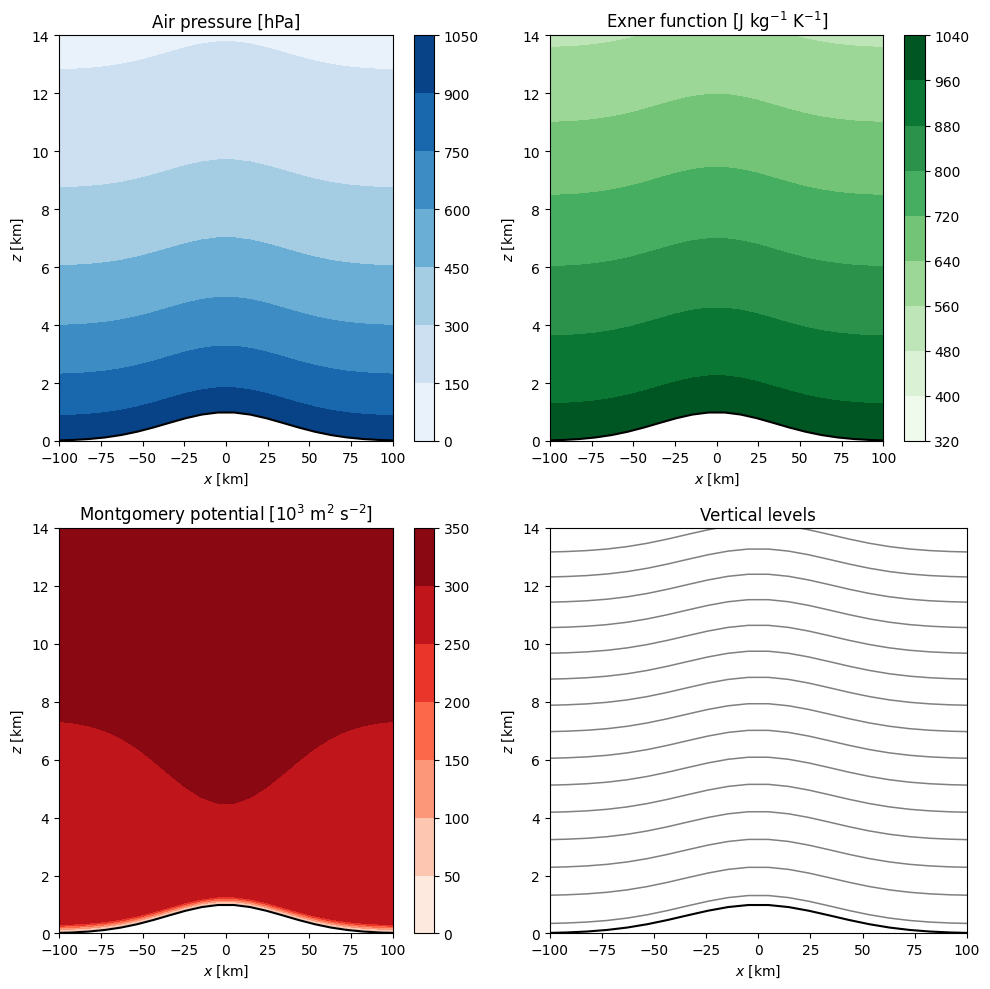

In [4]:
out_p = np.asarray(out_p)
out_exn = np.asarray(out_exn)
out_mtg = np.asarray(out_mtg)

j = int(ny / 2)
xx = 1e-3 * np.repeat(x[:, j, np.newaxis], nz + 1, axis=1)
yy = 1e-3 * np.asarray(out_h[:, j, :])

fig = plt.figure(figsize=(10, 10))

ax00 = fig.add_subplot(2, 2, 1)
surf = ax00.contourf(xx, yy, 1e-2 * out_p[:, j, :], cmap="Blues")
plt.colorbar(surf, orientation="vertical")
ax00.plot(xx[:, -1], yy[:, -1], color="black", linewidth=1.5)
ax00.set_xlim((-100, 100))
ax00.set_xlabel("$x$ [km]")
ax00.set_ylim((0, 14))
ax00.set_ylabel("$z$ [km]")
ax00.set_title("Air pressure [hPa]")

ax01 = fig.add_subplot(2, 2, 2)
surf = ax01.contourf(xx, yy, out_exn[:, j, :], cmap="Greens")
ax01.plot(xx[:, -1], yy[:, -1], color="black", linewidth=1.5)
plt.colorbar(surf, orientation="vertical")
ax01.set_xlim((-100, 100))
ax01.set_xlabel("$x$ [km]")
ax01.set_ylim((0, 14))
ax01.set_ylabel("$z$ [km]")
ax01.set_title("Exner function [J kg$^{-1}$ K$^{-1}$]")

ax10 = fig.add_subplot(2, 2, 3)
surf = ax10.contourf(xx, yy, 1e-3 * out_mtg[:, j, :], cmap="Reds")
ax10.plot(xx[:, -1], yy[:, -1], color="black", linewidth=1.5)
plt.colorbar(surf, orientation="vertical")
ax10.set_xlim((-100, 100))
ax10.set_xlabel("$x$ [km]")
ax10.set_ylim((0, 14))
ax10.set_ylabel("$z$ [km]")
ax10.set_title("Montgomery potential [10$^3$ m$^2$ s$^{-2}$]")

ax11 = fig.add_subplot(2, 2, 4)
for k in range(0, nz, 3):
    ax11.plot(xx[:, k], yy[:, k], color="gray", linewidth=1.1)
ax11.plot(xx[:, -1], yy[:, -1], color="black", linewidth=1.5)
ax11.set_xlim((-100, 100))
ax11.set_xlabel("$x$ [km]")
ax11.set_ylim((0, 14))
ax11.set_ylabel("$z$ [km]")
ax11.set_title("Vertical levels")

# fig.suptitle("Diagnostic fields at $y = {:3.3f}$ km".format(1e-3*y1d[j]))
fig.tight_layout()

In [5]:
# This cell only works in Jupyter Lab with itkwidgets extension.
# Installation commands:
#!pip install jupyterlab itkwidgets
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager itkwidgets

# import itkwidgets
# v = itkwidgets.view(out_mtg, rotate=True)
# v